# K-Means Clustering

K-means is an **unsupervised learning** algorithm that learns the features of a dataset and assigns groups ("k" clusters) based on similarities. These groups are classified by their distance to a **centroid**, which is the mean average of a cluster group. K-means can help identify data points that exhibit similar behaviors. This can be used to find trends in the existing data and/or categorize new data points that have similar features to the established cluster groups.

![kmeans cluster](https://blog.floydhub.com/content/images/2019/04/kmeans3.gif)
Image source: [FloydHub Blog - Introduction to K-Means Clustering in Python with scikit-learn](https://blog.floydhub.com/introduction-to-k-means-clustering-in-python-with-scikit-learn/)

In [1]:
from sklearn.cluster import KMeans

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

%matplotlib inline

# Market Basket Analysis

In this lesson, we will visually analyze demographic information for customers at a shopping mall. Then using K-Means clustering, we will determine spending behavior groups for customers based on income and spending score. `Spending Score` is a value between 1-100 that identifies how frequent a customer shops and/or how much money they typically spend. High spending scores means that a customer shops often/spends a lot, whereas a low spending score means that the customer shops infrequently/spends little.

Data source: [Kaggle - Mall Customer Segmentation](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

In [2]:
# read file into dataframe
filepath = "Data.Files\\Mall_Customers.csv"

df = pd.read_csv(filepath)
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# remove CustomerID column
df.drop('CustomerID', axis=1, inplace=True)

In [4]:
# rename column headers
colheader = {'Genre': 'Gender',
             'Annual Income (k$)': 'Income', 
             'Spending Score (1-100)':'Score'}

df.rename(columns=colheader, inplace=True)

In [5]:
# verify updated column names
df.head()

,Gender,Age,Income,Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


## Statistical Analysis

Before using the K-Means algorithm to find similar shopping groups, we will explore the distributions for the features of our data, as well as some descriptive statistics. This may be useful to determine how many clusters we should set the K-Means algorithm to assign the customers.

In [6]:
# check for missing values
df.isnull().sum()

Gender    0
Age       0
Income    0
Score     0
dtype: int64

In [7]:
# overall descriptive statistics
df.describe()

,Age,Income,Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Gender', ylabel='count'>

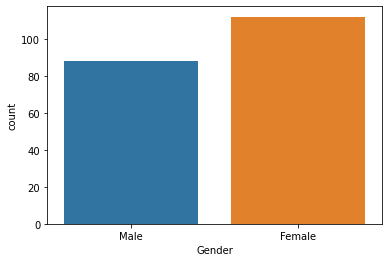

In [8]:
# number of customers by gender
sns.countplot(df['Gender'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

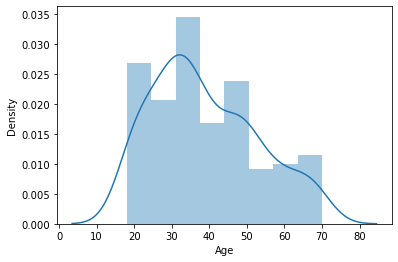

In [9]:
# distribution of customer age
sns.distplot(df['Age'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Income', ylabel='Density'>

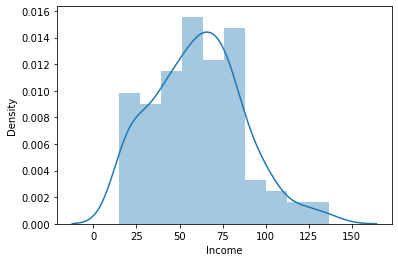

In [10]:
# distribution of customer income
sns.distplot(df['Income'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Score', ylabel='Density'>

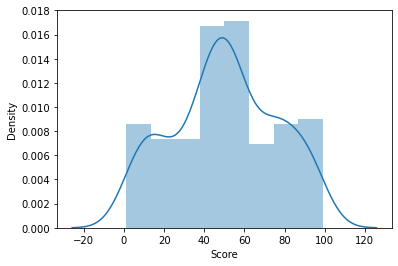

In [11]:
# distribution of customer spending score
sns.distplot(df['Score'])

To get a better sense of customer shopping habits, we will aggregate them by age and income.

In [12]:
# function to assign age groups
def age_groups(age):
    if age <= 25:
        group = '18-25'
    elif age <= 40:
        group = '26-40'
    elif age < 60:
        group = '40-59'
    elif age >= 60:
        group = '60+'
        
    return group

In [13]:
# use function on "Age" column
df['age_groups'] = df['Age'].apply(age_groups)

In [14]:
df

,Gender,Age,Income,Score,age_groups
0,Male,19,15,39,18-25
1,Male,21,15,81,18-25
2,Female,20,16,6,18-25
3,Female,23,16,77,18-25
4,Female,31,17,40,26-40
...,...,...,...,...,...
195,Female,35,120,79,26-40
196,Female,45,126,28,40-59
197,Male,32,126,74,26-40
198,Male,32,137,18,26-40


#### STEP 1: create the bin limits #### Another way to do the same thing

bins = [18, 25, 40, 60, 150]

the bin limits are the cutoff points for the values
each number shown is the cutoff for a specific group (0-60, 60.1 - 70, 70.1 - 80...)

bin_labels = ["18-25", "26-40", "40-59", "60+"]

the bin labels are the group names that will be created
there should always be one less group than bins

#### STEP 2: apply your bins to a specific column (or create new column) in dataset  ####
new column = pd.cut(column to apply to, bin cutoff list, labels = list of bin labels)
pd.cut function segments and organizes values into the appropriate bin

df["Age_Groups"] = pd.cut(df["Age"], bins, labels = bin_labels)

#### STEP 3: check changes  ####

df

In [15]:
# function to assign income groups
def income_groups(income):
    if income < 35:
        group = 'under $35K'
    elif income < 65:
        group = '$35-64K'
    elif income < 100:
        group = '$65-100K'
    elif income >= 100:
        group = '$100K+'
        
    return group

In [16]:
# use function on "Income" column
df['income_groups'] = df['Income'].apply(income_groups)

In [17]:
# verify changes to dataframe
df.head()

,Gender,Age,Income,Score,age_groups,income_groups
0,Male,19,15,39,18-25,under $35K
1,Male,21,15,81,18-25,under $35K
2,Female,20,16,6,18-25,under $35K
3,Female,23,16,77,18-25,under $35K
4,Female,31,17,40,26-40,under $35K


In [18]:
# mean average spending by gender
pd.pivot_table(data=df, index='Gender', values='Score')

,Score
Gender,
Female,51.526786
Male,48.511364


In [19]:
# mean average spending score by age group
pd.pivot_table(data= df, index=['age_groups'], values=['Score'])

,Score
age_groups,
18-25,54.947368
26-40,61.261905
40-59,33.551724
60+,43.000000


In [20]:
# mean average spending score by income group
pd.pivot_table(data= df, index=['income_groups'], values=['Score'])

,Score
income_groups,
$100K+,48.785714
$35-64K,50.065789
$65-100K,51.138889
under $35K,49.210526


In [21]:
index_val = ['Gender', 'age_groups', 'income_groups']

# mean average spending score by gender, age group, and income group
pd.pivot_table(data= df, index=index_val, values=['Score'])

Score
Gender age_groups income_groups           
Female 18-25      $35-64K        55.125000
                  $65-100K       40.250000
                  under $35K     71.375000
       26-40      $100K+         69.400000
                  $35-64K        46.461538
                  $65-100K       70.000000
                  under $35K     56.750000
       40-59      $100K+         21.250000
                  $35-64K        47.933333
                  $65-100K       29.400000
                  under $35K     16.166667
       60+        $35-64K        49.285714
                  $65-100K       43.000000
Male   18-25      $35-64K        56.625000
                  $65-100K        8.000000
                  under $35K     71.666667
       26-40      $100K+         50.200000
                  $35-64K        54.400000
                  $65-100K       67.200000
                  under $35K     52.800000
       40-59      $35-64K        47.272727
                  $65-100K       19.800000
                  under $35K     16.500000
       60+        $35-64K        50.111111
                  under $35K      7.000000

Customers that are 60+ and have an income under $35K do not shop frequently and spend little money. However, 18-25 year old customers in the same income group have a high spending score, despite the fact that they might not have much discretionary income.

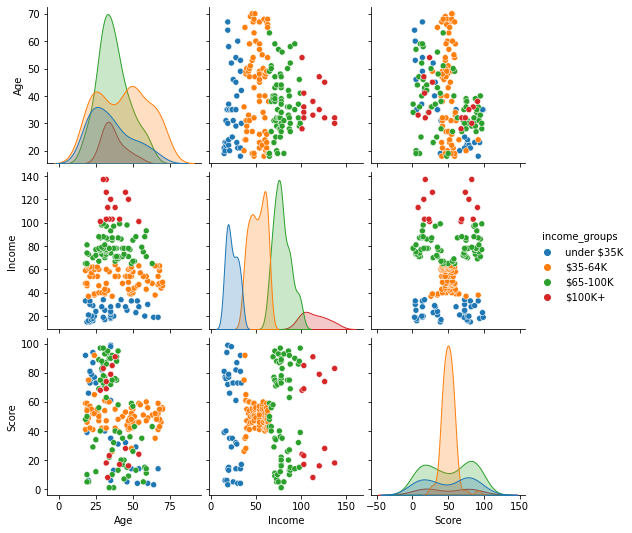

In [22]:
# compare all numerical features by income group
sns.pairplot(data=df, hue="income_groups")

# K-Means Model

Although there is some overlap in customer characteristics, when comparing `Income` (x-axis) to `Score` (y-axis) there are some distinctions that seem to form about five groups.

We will use the `KMeans` function to create five clusters (`n_clusters=`) and analyze the characteristics of each cluster. In the K-Means algorithm, every data point (row) **must be assigned** to a cluster. No matter how far away a data point is from the rest of the dataset, it will be assigned to the cluster group of its closest centroid. (*Note: This differs from K-Nearest Neighbor which creates groups based on how close the data points are to each other.*)

In [23]:
# dataframe that will be used in algorithm
X = df[['Age', 'Income', 'Score']]
X

,Age,Income,Score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


In [24]:
# initialize KMeans to create 5 clusters
kmeans = KMeans(n_clusters=5)

In [25]:
# build the model
# determine centroid position, then assign data to groups based on closest centroid
kmeans.fit(X)

KMeans(n_clusters=5)

In [26]:
len(df)

200

In [27]:
# centroid row position DOES NOT MATTER
# centroid columns are in order of dataframe columns index(0=Age, 1=Income, 2=Score)
kmeans.cluster_centers_

array([[45.2173913 , 26.30434783, 20.91304348],
       [32.69230769, 86.53846154, 82.12820513],
       [40.66666667, 87.75      , 17.58333333],
       [24.96      , 28.04      , 77.        ],
       [43.72727273, 55.48051948, 49.32467532]])

array([[45.2173913 , 26.30434783, 20.91304348],
       [32.69230769, 86.53846154, 82.12820513],
       [43.08860759, 55.29113924, 49.56962025],
       [25.52173913, 26.30434783, 78.56521739],
       [40.66666667, 87.75      , 17.58333333]])

array([[40.66666667, 87.75      , 17.58333333],
       [43.08860759, 55.29113924, 49.56962025],
       [25.52173913, 26.30434783, 78.56521739],
       [45.2173913 , 26.30434783, 20.91304348],
       [32.69230769, 86.53846154, 82.12820513]])

In [28]:
# create column in original dataframe with cluster group number
df['cluster'] = kmeans.labels_
df.head()

,Gender,Age,Income,Score,age_groups,income_groups,cluster
0,Male,19,15,39,18-25,under $35K,0
1,Male,21,15,81,18-25,under $35K,3
2,Female,20,16,6,18-25,under $35K,0
3,Female,23,16,77,18-25,under $35K,3
4,Female,31,17,40,26-40,under $35K,0


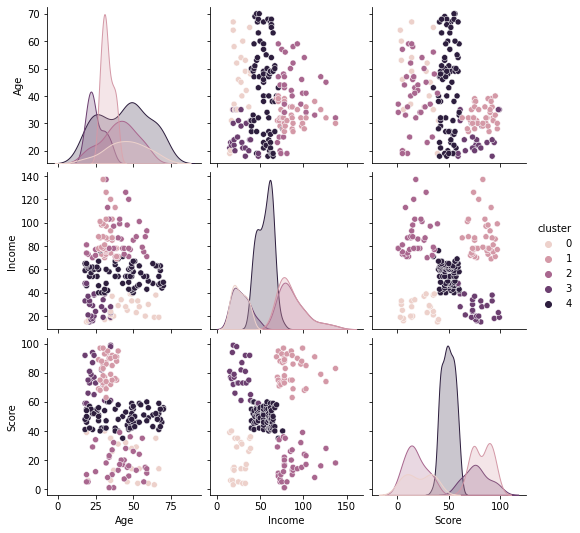

In [29]:
# compare all numerical features by cluster group
sns.pairplot(data=df, hue='cluster')

## Cluster Analysis

The plot comparing `Income` and `Score` has the most distinction with the clusters, so let's explore the locations of the centroids. Then we will analyze the cluster groups to determine the characteristics of the customer segments.

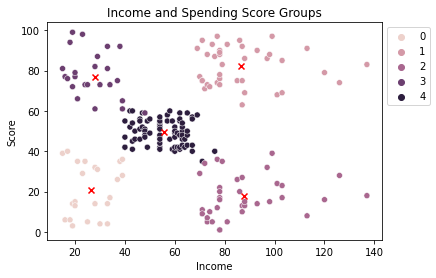

In [30]:
# compare "Income" and "Score"
sns.scatterplot(data=df, x='Income', y='Score', hue='cluster')

# scatterplot of centroid coordinates for income and spending score
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red', marker='x')

plt.title("Income and Spending Score Groups")
#put the legend on the right
plt.legend(bbox_to_anchor=(1,1), loc=2)

In [31]:
# select a cluster from dataframe
cluster = df.loc[df['cluster'] == 0]
cluster.head()

,Gender,Age,Income,Score,age_groups,income_groups,cluster
0,Male,19,15,39,18-25,under $35K,0
2,Female,20,16,6,18-25,under $35K,0
4,Female,31,17,40,26-40,under $35K,0
6,Female,35,18,6,26-40,under $35K,0
8,Male,64,19,3,60+,under $35K,0


In [32]:
# number of customers in this cluster
len(cluster)

23

In [33]:
# descriptive statistics for this cluster
cluster.describe()

,Age,Income,Score,cluster
count,23.000000,23.000000,23.000000,23.0
mean,45.217391,26.304348,20.913043,0.0
std,13.228607,7.893811,13.017167,0.0
min,19.000000,15.000000,3.000000,0.0
25%,35.500000,19.500000,9.500000,0.0
50%,46.000000,25.000000,17.000000,0.0
75%,53.500000,33.000000,33.500000,0.0
max,67.000000,39.000000,40.000000,0.0


### Analyze income range of clusters

In [34]:
# sort the cluster numbers from min(0) to max(4)
sorted_clusters = sorted(df['cluster'].unique())

# select the rows of the same cluster number
# then get min/max income and average spending score
print("Cluster Income Ranges\n")
for cluster_num in sorted_clusters:
    small_df = df.loc[df['cluster'] == cluster_num]
    min_income = small_df['Income'].min()
    max_income = small_df['Income'].max()
    avg_score = small_df['Score'].mean()
    
    print(f"Cluster {cluster_num}: ${min_income}-{max_income}K, avg score: {int(avg_score)}")

Cluster Income Ranges

Cluster 0: $15-39K, avg score: 20
Cluster 1: $69-137K, avg score: 82
Cluster 2: $70-137K, avg score: 17
Cluster 3: $15-48K, avg score: 77
Cluster 4: $40-76K, avg score: 49


### Customer Segments

After analyzing the income ranges and average spending score of each clusters, we identified these groups of shopper behavior:

- lower income, infrequently shops
- high income, infrequently shops
- average income, moderately shops
- lower income, frequently shops
- high income, frequently shops

This information can be used to classify a new customer that has recently started shopping at the store.

In [35]:
# new customer with Age=32, Income=$75K, and spending score=68
customer = [32, 75, 68]

customer_group = kmeans.predict([customer])

print(f"Cluster assignment: {customer_group}")

Cluster assignment: [1]


## Conclusions

This customer is assigned to the group of shoppers that have a high income and frequently shop. Although we don't need to offer them many incentives to shop at the store, if there is a customer loyalty program then this customer could be upgraded to a higher tier so that they will continue to be a dedicated shopper.